# __Data Mining 27__

### Features that are going to be used in the model (based on RFM model + other features)
- __Recency__ -> How recently has a customer used the service:
    - last time a customer went to the gym: **'n_sinceLastVisit'**
<br><br>    
- __Frequency__ -> How often has a customer used the service, variables that are going to be used:

    - going to the gym: **'n_frequenciesWeek'**
    - going to a class: **'n_classesWeek'**
<br><br>
- __Monetary value__ -> How much money has a customer spent or can spend:

    - average spend per month: **'n_spendMonth'**
    - spend rate (how much a customer is spending per month vs its income): **'n_spendRate'**
<br><br>
- __Loyalty__ -> How long has a customer been a customer:
    - time as a customer: **'n_timeAsCustomer'**

In [107]:
import pandas as pd
import numpy as np 
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns


# Scalers 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Imputers
from sklearn.impute import KNNImputer

In [158]:
data = pd.read_csv('../Datasets/XYZ_sports_dataset.csv', sep=';')
data_original = data.copy()

### __1. First analysis and selection with pandas profiling__

##### 0. Profiling

In [109]:
# Lets make a profiling report
#profile = pandas_profiling.ProfileReport(data)
#profile.to_file(outputfile="XYZ_sports_dataset.html")

##### 1. Constant features
- DanceActivities
- NatureActivities

In [110]:
data = data.drop(['DanceActivities', 'NatureActivities'], axis=1)

##### 2. Quasi-constant features (highly inbalanced)
- OtherActivities (98.0%)
- AtheleticsActivities (93.7%)
- NumberOfReferences (92.4%)

Using a threshold of 90%. Variables not listed have a lower percentage of imbalance.

In [111]:
dropped = data[['OtherActivities', 'NumberOfReferences', 'AthleticsActivities']]
data = data.drop(['OtherActivities', 'NumberOfReferences', 'AthleticsActivities'], axis=1)

##### 3. Uniform features that provide no information 
Since all values are unique and they dont provide any kind of ordinal information, they are removed.
- ID

In [112]:
data = data.drop(['ID'], axis=1)

##### 4. Get rid of duplicates 

In [113]:
# Search and delete duplicates
print('Number of duplicates:', data.duplicated().sum())
data = data.drop_duplicates()

Number of duplicates: 1


### __2. Feature name change for better understanding__
Like this, I will be able to access them more easily and understand what they are.
1. Binary will start with a b
2. Numerical will start with n
3. Date will start with d

In [114]:
data.columns = ['n_age', 'b_gender', 'n_income', 'd_enrollmentStart', 'd_enrollmentFinish', 'd_lastPeriodStart', 'd_lastPeriodFinish', 'd_lastVisit', 'n_daysWithoutFrequency', 'n_lifetimeValue',
                'b_useByTime', 'b_waterActivities', 'b_fitnessActivities', 'b_teamActivities', 'b_racketActivities', 'b_combatActivities', 'b_specialActivities', 'n_frequencies',
                'n_attendedClasses', 'n_allowedWeeklyVisits', 'n_allowedVisits', 'n_realVisits', 'n_renewals', 'b_hasReferences', 'b_dropout']

data['b_gender'] = data['b_gender'].map({'Male' : 0, 'Female' : 1})

Lets recheck the imbalances in the binary and numerical features <br><br>
__1. Binary features__

In [115]:
binary_features = [col for col in data.columns if col.startswith('b_')]

balance = {}
for feature in binary_features:
    value_counts = data.value_counts(feature)
    balance[feature] = 100* round(value_counts.min() / value_counts.max(),3)

balance = pd.DataFrame.from_dict(balance, orient='index', columns=['balance'])
balance = balance.sort_values(by='balance', ascending=False)
balance

,balance
b_fitnessActivities,73.6
b_gender,67.3
b_waterActivities,42.1
b_dropout,24.9
b_combatActivities,12.1
b_teamActivities,5.9
b_useByTime,4.9
b_specialActivities,2.7
b_racketActivities,2.4
b_hasReferences,2.0


Segmenting customers in such smalls groups is not the best idea (2% of the data). Lets set the threshold to 3% and remove the features that have less than that. 
We will, of course, keep a backup of the dropped features, because they might be useful for feature engineering:
- Joining the very unlikely activities into one feature might prove useful, but that's an idea for later

In [116]:
# Remove features with balance < 3%
remove = balance[balance['balance'] < 3].index.to_list()
dropped = pd.concat([data[remove], dropped], axis=1)
data = data.drop(remove, axis=1)


__2. Numerical Features__

In [117]:
numerical_features = [col for col in data.columns if col.startswith('n_')]

In [118]:
data[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
n_age,14941.0,26.016732,14.156592,0.00,19.00,23.00,31.00,87.00
n_income,14446.0,2230.970511,1566.471988,0.00,1470.00,1990.00,2790.00,10890.00
n_daysWithoutFrequency,14941.0,81.227629,144.204026,0.00,13.00,41.00,84.00,1745.00
n_lifetimeValue,14941.0,302.577212,364.326932,0.00,83.60,166.20,355.10,6727.80
n_frequencies,14915.0,40.122293,65.468305,1.00,7.00,18.00,45.00,1031.00
n_attendedClasses,14941.0,10.152667,29.155167,0.00,0.00,0.00,3.00,581.00
n_allowedWeeklyVisits,14406.0,5.759614,2.118931,1.00,4.00,7.00,7.00,7.00
n_allowedVisits,14941.0,41.636121,21.066860,0.56,25.72,38.99,60.97,240.03
n_realVisits,14941.0,5.320394,6.333055,0.00,1.00,4.00,7.00,84.00
n_renewals,14941.0,1.205274,1.381350,0.00,0.00,1.00,2.00,6.00


### __3. Dealing with missing values:__ 
- Median imputation for binary features
- KNN imputation for numerical features

In [119]:
def get_missing(data):
    return 100*data.isna().sum()[data.isna().sum() != 0].sort_values(ascending=False)/data.shape[0]

get_missing(data)

n_allowedWeeklyVisits    3.580751
n_income                 3.313031
b_waterActivities        0.247641
b_fitnessActivities      0.234255
b_teamActivities         0.234255
b_combatActivities       0.220869
n_frequencies            0.174018
dtype: float64

__1. Binary features:__ we will fill with the most frequent value (mode), because it will not skew the data too much and we have very few missing values. 

In [120]:
to_impute = ['b_waterActivities', 'b_fitnessActivities', 'b_teamActivities', 'b_combatActivities']
modes = data[to_impute].mode().iloc[0].to_dict()

# Impute missing values
data[to_impute] = data[to_impute].fillna(modes)

__2. Numerical features:__ lets use a KNN imputer, because it will be able to fill the missing values with a more accurate value than the mean or median.

In [121]:
# Lets start with getting the Nan indices
nan_indices = data[data['n_frequencies'].isna() | data['n_income'].isna() | data['n_allowedWeeklyVisits'].isna()].index

# First scale the numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Now fit the KNNImputer to the numerical features
imputer = KNNImputer(n_neighbors=5)
data[numerical_features] = imputer.fit_transform(data[numerical_features])

# Now we can inverse the scaling
data[numerical_features] = scaler.inverse_transform(data[numerical_features])

In [122]:
data.loc[nan_indices, numerical_features]

,n_age,n_income,n_daysWithoutFrequency,n_lifetimeValue,n_frequencies,n_attendedClasses,n_allowedWeeklyVisits,n_allowedVisits,n_realVisits,n_renewals
0,60.0,5500.0,1.0,89.35,9.0,7.0,3.0,6.28,2.0,0.0
19,28.0,2510.0,10.0,52.00,2.0,0.0,7.0,24.01,2.0,0.0
34,74.0,5210.0,20.0,38.50,4.0,0.0,7.0,30.03,4.0,0.0
68,43.0,4036.0,1.0,849.80,214.0,0.0,7.0,21.98,9.0,3.0
76,9.0,0.0,5.0,708.20,64.0,64.0,2.0,17.42,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...
14874,15.0,0.0,62.0,353.60,20.0,17.0,1.0,8.71,0.0,0.0
14898,23.0,1980.0,0.0,68.20,28.0,0.0,7.0,31.99,19.0,0.0
14904,21.0,1820.0,3.0,54.80,9.0,0.0,7.0,21.98,5.0,0.0
14930,4.0,686.0,38.0,77.60,5.0,5.0,2.0,17.42,7.0,1.0


### __4. Feature engineering__

In [123]:
data.columns

Index(['n_age', 'b_gender', 'n_income', 'd_enrollmentStart',
       'd_enrollmentFinish', 'd_lastPeriodStart', 'd_lastPeriodFinish',
       'd_lastVisit', 'n_daysWithoutFrequency', 'n_lifetimeValue',
       'b_useByTime', 'b_waterActivities', 'b_fitnessActivities',
       'b_teamActivities', 'b_combatActivities', 'n_frequencies',
       'n_attendedClasses', 'n_allowedWeeklyVisits', 'n_allowedVisits',
       'n_realVisits', 'n_renewals', 'b_dropout'],
      dtype='object')

##### __Age class:__

In [124]:
data['c_age'] = pd.cut(data['n_age'], bins=[-1, 5, 20, 35, 49, 65, np.inf], labels=['<5','5-20', '20-35', '35-49', '49-65', '65+'])
data['c_age'].value_counts(dropna=False)

20-35    7246
5-20     3874
35-49    1750
<5        927
49-65     836
65+       308
Name: c_age, dtype: int64

It is quite odd that we have values for age that are bellow 5, but these are probably babies that are learning how to swim

#### __Durations__ 

##### __Enrollment duration + categorical:__

In [140]:
data['n_timeAsCustomer'] = ((pd.to_datetime(data['d_enrollmentFinish']) - pd.to_datetime(data['d_enrollmentStart'])).dt.days).astype(float)
data['n_timeAsCustomer'].describe()

count    14941.000000
mean       295.718493
std        356.829856
min          0.000000
25%         57.000000
50%        174.000000
75%        364.000000
max       1938.000000
Name: n_timeAsCustomer, dtype: float64

We dont want enrollment durations of 0, as these are probably errors. We have to investigate this further.

In [141]:
data[data['n_timeAsCustomer'] == 0]['b_dropout'].mean()

0.0

This means that if we have a customer that has an enrollment duration of 0 he never dropped out. Lets then impute the 0 values with the maximum value of the enrollment duration.

In [142]:
data['n_timeAsCustomer'] = data.apply(lambda x: (pd.to_datetime('2019-10-31') - pd.to_datetime(x['d_enrollmentStart'])).days if x['n_timeAsCustomer'] == 0 else x['n_timeAsCustomer'], axis=1)
data['c_timeAsCustomer'] = pd.cut(data['n_timeAsCustomer'], bins=[-0.1, 30, 90, 180, 365, np.inf], labels=['<1m', '1-3m', '3-6m', '6-12m', '12m+'])
data['c_timeAsCustomer']

0         1-3m
1         12m+
2          <1m
3         3-6m
4         12m+
         ...  
14937     12m+
14938    6-12m
14939      <1m
14940     12m+
14941     12m+
Name: c_timeAsCustomer, Length: 14941, dtype: category
Categories (5, object): ['<1m' < '1-3m' < '3-6m' < '6-12m' < '12m+']

In [143]:
# Remove the date columns
data = data.drop(['d_enrollmentStart', 'd_enrollmentFinish'], axis=1)

##### __Last period duration:__

In [144]:
data['n_lastPeriodDuration'] = (pd.to_datetime(data['d_lastPeriodFinish']) - pd.to_datetime(data['d_lastPeriodStart'])).dt.days
# Remove the date columns
data = data.drop(['d_lastPeriodStart', 'd_lastPeriodFinish'], axis=1)

##### __Days since last visit + categorical:__

In [145]:
print('Last data available on:', data['d_lastVisit'].value_counts().sort_index(ascending=False).index[0])
data['n_sinceLastVisit'] = (pd.to_datetime(data['d_lastVisit']).max() - pd.to_datetime(data['d_lastVisit'])).dt.days

data['c_sinceLastVisit'] = pd.cut(data['n_sinceLastVisit'], bins=[-1, 7, 14, 30, 60, 90, 365, np.inf], labels=['<1w', '1-2w', '2-4w', '1-2m', '2-3m', '3-12m', '>12m'])
print(data['c_sinceLastVisit'].value_counts(dropna=False))

# Remove the date columns
data = data.drop(['d_lastVisit'], axis=1)

Last data available on: 2019-10-31


#### __Relative features__

##### __Number of frequencies per week + categorical:__ 
- The number of frequencies is the number of times a customer went to the facility during its enrollment period.
- We will also delete the number of freqeuncies, as the number of frequencies per week is a better feature.

In [130]:
data['n_frequenciesWeek'] = 7 * data['n_frequencies'] / (data['n_enrollmentDuration'])
# Make a categorical feature
data['c_frequenciesWeek'] = pd.cut(data['n_frequenciesWeek'], bins=[-1, 0.1, 0.2, 0.5, 1, 2, 3, np.inf], labels=['<0.1', '0.1-0.2', '0.2-0.5', '0.5-1', '1-2', '2-3', '>3'])
data['c_frequenciesWeek'].value_counts()

0.5-1      4437
0.2-0.5    4351
1-2        2695
0.1-0.2    1544
<0.1       1126
2-3         620
>3          168
Name: c_frequenciesWeek, dtype: int64

In [131]:
# Drop the original features
dropped = pd.concat([dropped, data[['n_frequencies']]], axis=1)
data = data.drop(['n_frequencies'], axis=1)

##### __Attended classes per week + categorical:__
- The number of attended classes per week is the number of times a customer attended a class during its enrollment period.
- We will also delete the number of attended classes, as the number of attended classes per week is a better feature.

In [150]:
data['n_classesWeek'] = 7 * data['n_attendedClasses'] / (data['n_enrollmentDuration'])
data['c_classesWeek'] = pd.cut(data['n_classesWeek'], bins=[-1, 0, 0.1, 0.5, 1, np.inf], labels=['0', '<0.1', '0.1-0.5', '0.5-1', '>1'])
print(data['c_classesWeek'].value_counts())
# Drop the n_attendedClasses
dropped = pd.concat([dropped, data[['n_attendedClasses']]], axis=1)
data = data.drop(['n_attendedClasses'], axis=1)

0          10432
0.1-0.5     2239
0.5-1       1150
<0.1         812
>1           308
Name: c_classesWeek, dtype: int64


##### __Service utilization + categorical:__

In [132]:
data['n_ratioUtilization'] = 100 * data['n_realVisits'] / data['n_allowedVisits']
data['n_ratioUtilization'].describe()   

count    14941.000000
mean        15.694226
std         18.079938
min          0.000000
25%          3.224766
50%          9.990010
75%         22.962113
max        254.017626
Name: n_ratioUtilization, dtype: float64

Lets cap it at 100, otherwise it doesnt make sense.

In [151]:
data.loc[data['n_ratioUtilization'] > 100, 'n_ratioUtilization'] = 100
print(data['n_ratioUtilization'].describe())
data['c_utilization'] = pd.cut(data['n_ratioUtilization'], bins=[-1, 25, 50, 75, np.inf], labels=['<25%', '25-50%', '50-75%', '>75%']) 

count    14941.000000
mean        15.608739
std         17.539408
min          0.000000
25%          3.224766
50%          9.990010
75%         22.962113
max        100.000000
Name: n_ratioUtilization, dtype: float64


#### __Monetary features__

__Spent per month:__
- Problem: people pay for their membership in advance, so there wil be noise added for people with a lot of months left in their membership. Moreover, people that have just subscribed will have an even larger value. 

<Axes: title={'center': 'Enrollment duration vs renewals'}, xlabel='n_enrollmentDuration', ylabel='n_renewals'>

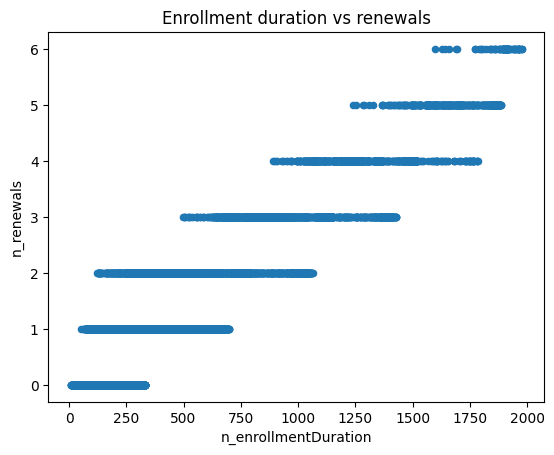

In [209]:
data.plot.scatter(x='n_enrollmentDuration', y='n_renewals', title='Enrollment duration vs renewals')    

As we can see there is a very large correaltion between the number of renewals and the enrollment duration 

In [264]:
# Spent per month 
data['n_spentPerMonth'] = data['n_lifetimeValue'] / (data['n_renewals'] + 1)
data['n_spentPerMonth'].describe()

count    14941.000000
mean       125.555951
std         90.084350
min          0.000000
25%         59.533333
50%         99.700000
75%        168.900000
max       1681.950000
Name: n_spentPerMonth, dtype: float64

### __5. Variable correlations__
- Correlation between numerical variables

__Numerical features__

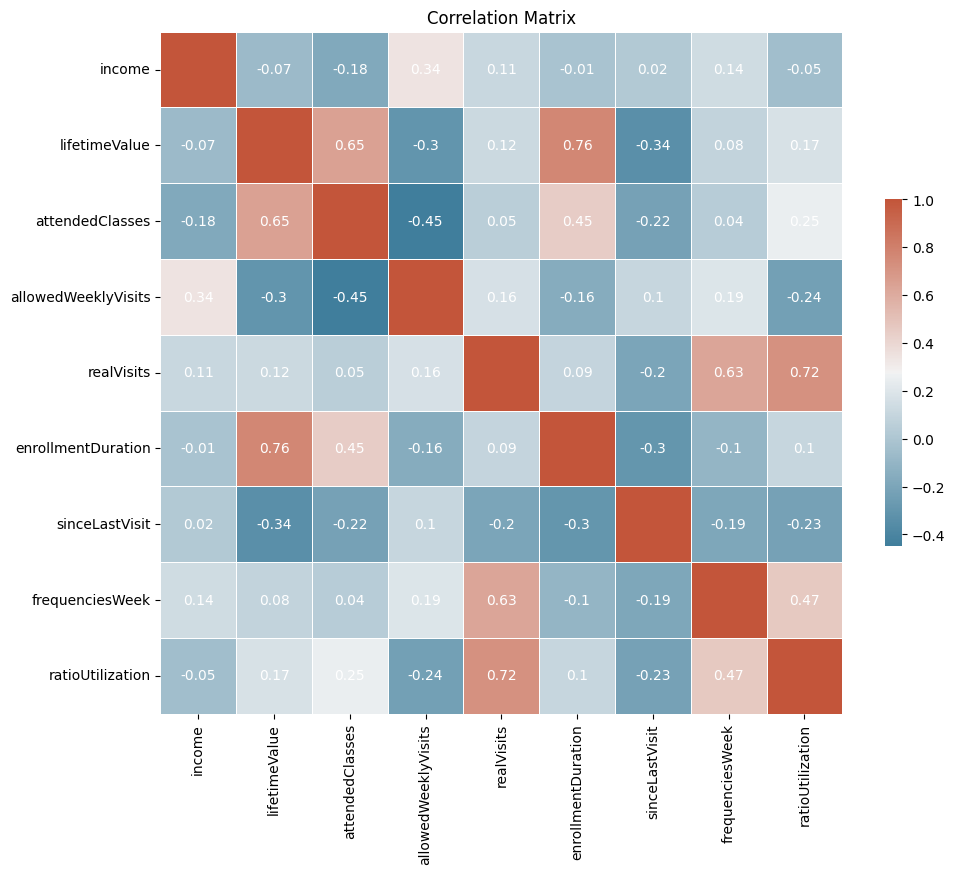

In [92]:
numerical_features = [col for col in data.columns if col.startswith('n_')]

# Correlation between numerical features sns
corr = data[numerical_features].corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Remove the n_ prefix
corr.columns = corr.columns.str.replace('n_', '')
corr.index = corr.index.str.replace('n_', '')
sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# Add annotation
for i in range(len(corr)):
    for j in range(len(corr)):
        if i != j:
            ax.text(i+0.5, j+0.5, round(corr.iloc[i,j],2), ha="center", va="center", color="w")
ax.set_title('Correlation Matrix')
plt.show()

1. High correlations -> between age and income and renewals and enrollmentDuration, we can drop the age (which will be used after the clustering algorithm is done for visualization) and the renewals, because the renewals are less correlated with the other variables than the enrollment duration -> $[age, renewals]$

2. Low correlations -> lastPeriodDuration is not correlated with anything really -> $[lastPeriodDuration]$

3. Allowed weekly visits is highly correlated with the total number of allowed visits, so we will drop the total allowed visits because it is less correlated with the other variables and because we already used it to create the ratioUtilization variable -> $[allowedVisits]$

4. We will also drop the daysWithoutFrequency variable, which means the number of days that a customer needed to not visit the facility to be considered a dropout, because of relevancy and low correlation to other features -> $[daysWithoutFrequency]$

In [89]:
dropped = pd.concat([data[['n_age', 'n_renewals', 'n_lastPeriodDuration', 'n_allowedVisits', 'n_daysWithoutFrequency']], dropped], axis=1)
data = data.drop(['n_age', 'n_renewals', 'n_lastPeriodDuration', 'n_allowedVisits', 'n_daysWithoutFrequency'], axis=1)

### __6. Outlier detection__